<div class="alert alert-block alert-success">
    <h3 align="center">Modelagem de Churn de Clientes</h3>
    <h4 align="center">Moisés Victor</h4>
</div>

In [1]:
# bibliotecas que serão utilizadas no projeto
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, auc

from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

import time

from sklearn.model_selection import KFold, GridSearchCV, KFold, cross_val_score, train_test_split
from imblearn.pipeline import Pipeline

from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler

### 1. Importar e limpar os dados <a id="1-importar-e-limpar-os-dados"></a>

In [2]:
# importar o dataset
df = pd.read_csv('IT_customer_churn.csv')
print(df.shape)

(7043, 20)


In [3]:
# visualizando os dados
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# obtendo informações de tipos de dados reconhecidos e se há valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
# verificando os valores existentes pra cada coluna
for coluna in df.columns:
    print(f'{coluna} : {df[coluna].unique()}')

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2

**Não há valores nulos na base de dados, porém há alguns problemas identificados:**

- **Coluna gender deve ser convertida para formato numérico. Uma possível solução é 'Male' = 1 e 'Female' = 0**
- **Colunas do tipo booleano: Transformar os valores 'Yes' para 1 e 'No' para 0 e então converter para tipo numérico.**
- **Coluna TotalCharges é o valor total pago pelo cliente até então. Esta coluna foi reconhecida como objeto e deve ser convertida pro formato de número.**
- **As colunas InternetService, Contract e PaymentMethod possuem valores categóricos. Será realizado o encoding para estas colunas.**

In [6]:
# converter a coluna TotalCharges para numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

- **Após transformar a coluna TotalCharges para numérico, alguns valores estavam preenchidos como espaço em branco (' '), portanto serão excluídos do modelo.**

In [7]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
df = df.dropna()
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 2. Visualizando os dados <a id="2-visualizando-os-dados"></a>

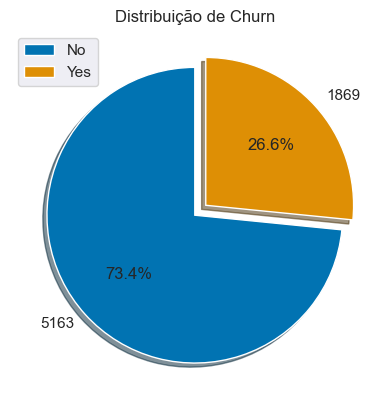

In [9]:
# Verificando a distribuição dos valores na feature Churn

# Contagem dos valores de Churn
data = df['Churn'].value_counts()

# Criação do gráfico de pizza com rótulos personalizados e uma legenda
sns.set_theme(style='dark', palette='colorblind', context='notebook')
fig, ax = plt.subplots()
ax.pie(x=data, labels=data.values, autopct='%1.1f%%', explode=(0, 0.1), shadow=True, startangle=90)
ax.legend(data.index)
plt.title("Distribuição de Churn")

# Exibição do gráfico
plt.show()


- **Com o gráfico acima, fica evidente o desbalancemaneto na ocorrência de Churn para este dataset**

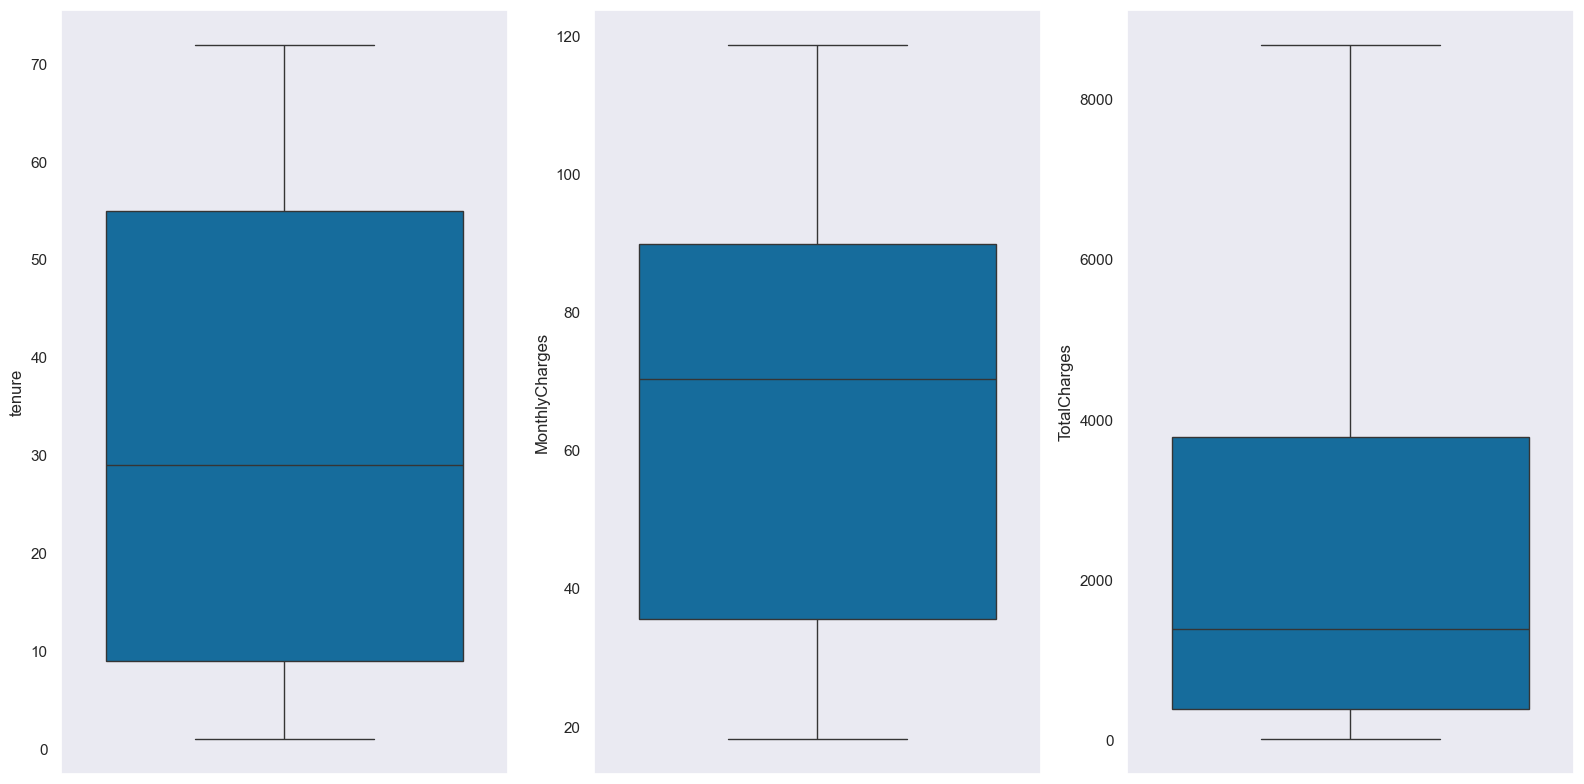

In [10]:
# verificando a presença de outliers nas colunas tenure, MonthlyCharges e TotalCharges
colunas_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.style.use('seaborn-v0_8-colorblind')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,8), tight_layout=True)
for i in range(len(colunas_numericas)):
    sns.boxplot(y=colunas_numericas[i], data=df, ax=axs[i])

- **Observa-se portanto que não há valores muito discrepantes para essas 3 features.**

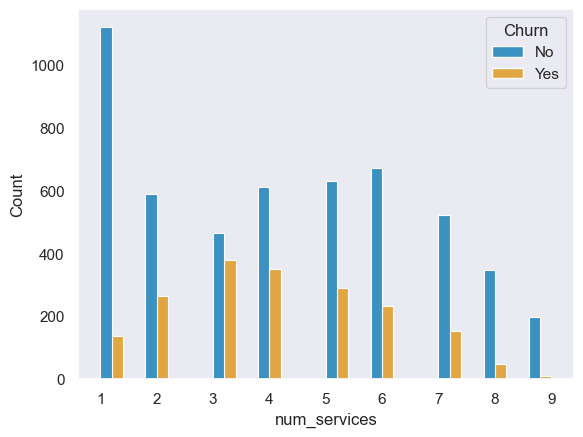

In [11]:
# Verificando o Churn com relação ao número de serviços contratados 

# Criando nova coluna com a quantidade de serviços adquiridos por cliente
df['internet'] = df['InternetService'].apply(lambda x: 'No' if x == 'No' else 'Yes')

df['num_services'] = (df[['PhoneService', 'OnlineSecurity',
                          'OnlineBackup', 'DeviceProtection',
                          'TechSupport', 'StreamingTV',
                          'StreamingMovies', 'internet', 'MultipleLines']] == 'Yes').sum(axis=1)

sns.set_theme(style='dark', palette='colorblind', context='notebook')

sns.histplot(x='num_services', data=df, hue='Churn', multiple='dodge')

plt.show()

In [12]:
# Verificando a percentagem de Churn em relação ao número de serviços contratados 
pd.crosstab(df["num_services"], df["Churn"], normalize="index", margins=True, margins_name="Total").mul(100).round(1)

Churn,No,Yes
num_services,,
1,89.0,11.0
2,69.0,31.0
3,55.1,44.9
4,63.5,36.5
5,68.6,31.4
6,74.4,25.6
7,77.4,22.6
8,87.6,12.4
9,94.7,5.3


- **Parece não haver correlação direta entre o número de serviços contratados e churn, mesmo assim iremos manter essa coluna no modelo**

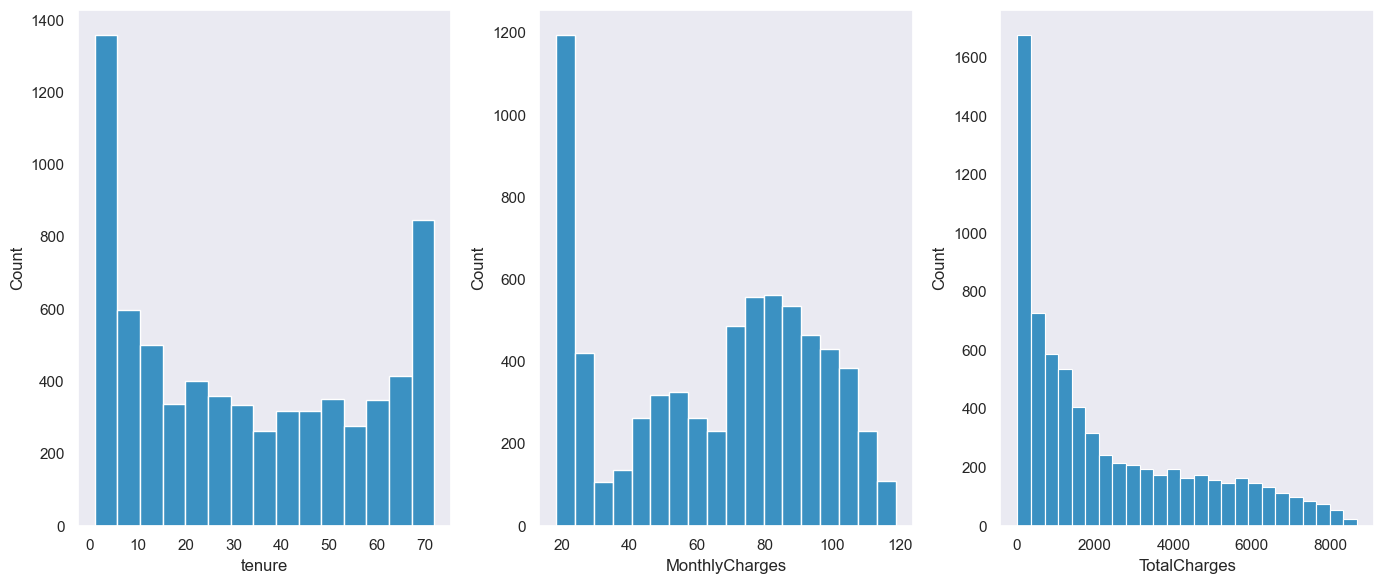

In [13]:
# Verificando a distribuição dos valores nas colunas numéricas

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,6), tight_layout=True)
for i in range(len(colunas_numericas)):
    sns.histplot(x=colunas_numericas[i], data=df, multiple='dodge', ax=axs[i])

plt.show()

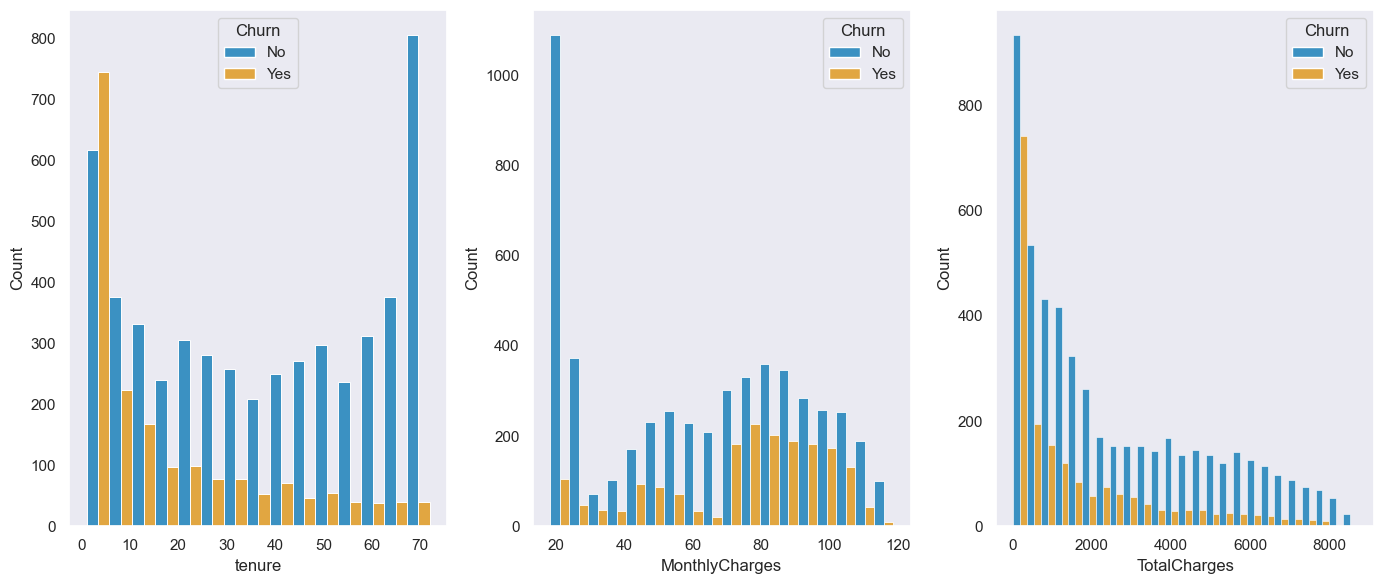

In [14]:
# Verificando a contagem de churn para cada variável numérica
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,6), tight_layout=True)

for i in range(len(colunas_numericas)):
    sns.histplot(x=colunas_numericas[i], data=df, hue='Churn', multiple='dodge', ax=axs[i])

plt.show()

- **É possível observar que o Churn tende a diminuir conforme os valores de 'tenure' (que indicam o tempo em meses do cliente na empresa) diminui**
- **O mesmo ocorre com os valores de TotalCharges**

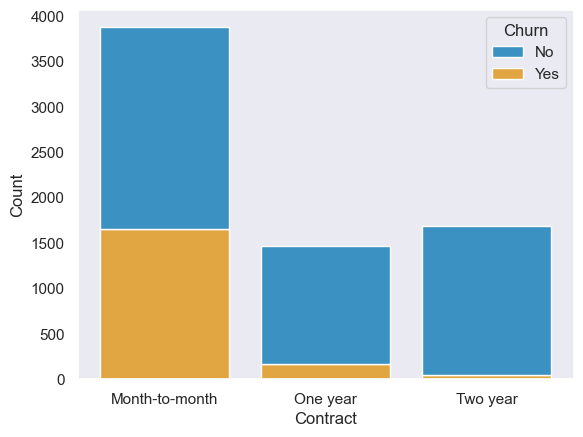

In [15]:
# Verificando o Churn por tipo de contrato
sns.histplot(x='Contract', data=df, hue='Churn', multiple='stack', shrink=0.8)
plt.show()

- **O Churn tende a diminuir conforme aumenta a duração do contrato. Isso explica o motivo de algumas empresas fornecerem descontos e atrativos para favorecer os contratos anuais**

### 3. Preparando os dados para o modelo de previsão

In [16]:
# converter a coluna gender para numérico: 'Male' = 1 e 'Female' = 0
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [17]:
colunas_bool = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'PaperlessBilling', 'Churn']

# converter todos os valores 'Yes' para 1 e os outros possíveis ('No', 'No internet service', 'No phone service') para 0 
for coluna in colunas_bool:
    df[coluna] = df[coluna].apply(lambda x: 1 if x == 'Yes' else 0)

#### 3.1. Feature Engineering

In [18]:
# Verifica se o cliente está comprometido com os serviços da empresa, ou seja, se o tipo de contrato for diferente de Mês-a-Mês, o valor retornado será 1 (Yes)
df['comprometido'] = np.where(df['Contract'] != 'Month-to-month', 1.0, 0.0)

# Verifica se o cliente possui algum tipo de serviço de proteção contratado e retorna 1 caso possua pelo menos um.
df['protecao'] = np.where((df['OnlineBackup'] != 0) | (df['DeviceProtection'] != 0) | (df['TechSupport'] != 0), 1.0, 0.0)

# Cliente Senior com Dependentes
df['senior_com_dependentes'] = np.where((df['SeniorCitizen'] == 1) & (df['Dependents'] == 1), 1.0, 0.0)

# Cliente jovem e comprometido
df['jovem_comprometido'] = np.where((df['SeniorCitizen'] == 0) & (df['Contract'] != 'Month-to-month'), 1.0, 0.0)

# Cliente com todos os serviços de proteção
df['todo_protegido'] = np.where((df['OnlineSecurity'] != 0) & (df['OnlineBackup'] != 0) & (df['DeviceProtection'] != 0), 1, 0)

# Cliente com Alta Fatura Mensal e Longo Tempo de Permanência 
df['alta_fatura_longo_tempo'] = np.where((df['MonthlyCharges'] > df['MonthlyCharges'].median()) & (df['tenure'] > df['tenure'].median()), 1.0, 0.0)

In [19]:
# obtendo novamente os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   7032 non-null   int64  
 1   SeniorCitizen            7032 non-null   int64  
 2   Partner                  7032 non-null   int64  
 3   Dependents               7032 non-null   int64  
 4   tenure                   7032 non-null   int64  
 5   PhoneService             7032 non-null   int64  
 6   MultipleLines            7032 non-null   int64  
 7   InternetService          7032 non-null   object 
 8   OnlineSecurity           7032 non-null   int64  
 9   OnlineBackup             7032 non-null   int64  
 10  DeviceProtection         7032 non-null   int64  
 11  TechSupport              7032 non-null   int64  
 12  StreamingTV              7032 non-null   int64  
 13  StreamingMovies          7032 non-null   int64  
 14  Contract                 7032

In [20]:
# fazendo o encoding para as colunas InternetService, Contract, PaymentMethod, num_services e internetd
colunas_categorias=['InternetService', 'Contract', 'PaymentMethod', 'num_services', 'internet']
df_cod = pd.get_dummies(data=df, columns=colunas_categorias, dtype=int)

In [21]:
# verificando novamente os valores existentes pra cada coluna
for coluna in df_cod.columns:
    print(f'{coluna} : {df_cod[coluna].unique()}')

gender : [0 1]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService : [0 1]
MultipleLines : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
TechSupport : [0 1]
StreamingTV : [0 1]
StreamingMovies : [0 1]
PaperlessBilling : [1 0]
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn : [0 1]
comprometido : [0. 1.]
protecao : [1. 0.]
senior_com_dependentes : [0. 1.]
jovem_comprometido : [0. 1.]
todo_protegido : [0 1]
alta_fatura_longo_tempo : [0. 1.]
InternetService_DSL : [1 0]
InternetService_Fiber optic : [0 1]
InternetService_No : [0 1]
Contract_Month-to-month : [1 0]
Contract_One year : [0 1]
Contract_Two year : [0 1]
PaymentMethod_Bank t

In [22]:
df_cod.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,num_services_2,num_services_3,num_services_4,num_services_5,num_services_6,num_services_7,num_services_8,num_services_9,internet_No,internet_Yes
0,0,0,1,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,1,0,0,0,34,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,2,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


- **Removendo colunas com alta correlação**

In [23]:
# Limite para remoção de variáveis altamente correlacionadas
limite_corr = 0.90

# Matriz de correlação de valor absoluto
corr_matrix = df_cod.corr().abs()

# Obtendo o triângulo superior de correlações
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Selecionando colunas com correlações acima do limite
para_remover = [column for column in upper.columns if any(upper[column] > limite_corr)]

print('Há %d colunas a remover' % (len(para_remover)))
print(list(para_remover))

Há 4 colunas a remover
['jovem_comprometido', 'Contract_Month-to-month', 'internet_No', 'internet_Yes']


In [24]:
df_cod = df_cod.drop(columns = para_remover)

#### 3.2. Normalizando os valores
**A normalização dos dados é crucial em muitos modelos de Machine Learning. Isso é feito para garantir que todas as variáveis estejam na mesma escala, o que ajuda a:**
- **Facilita a convergência mais rápida dos modelos durante o treinamento.**
- **Melhora a precisão das previsões dos modelos.**
- **Permite que os modelos aprendam pesos mais apropriados para cada característica.**

In [25]:
# criando o normalizador
scaler = MinMaxScaler(feature_range=(0, 1))
# ajustando o conjunto de dados no normalizador
normal = scaler.fit_transform(df_cod)
# criando o dataframe a partir dos dados normalizados
normal_df = pd.DataFrame(normal, columns= df_cod.columns)

In [26]:
# criando X e y a partir dos dados normalizados
X = normal_df.drop(columns='Churn', axis=1)
y = normal_df['Churn']

# criando X, y de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 39), (1407, 39), (5625,), (1407,))

### 4. Criando os diferentes modelos de classificação
- Escolha dos modelos a serem testados
  1. XGBClassifier
  2. ExtraTreesClassifier
  3. SVC
  4. RidgeClassifier
  5. DecisionTreeClassifier

#### 4.1. Antes de criar os modelos, vamos primeiro encontrar os melhores hiperparâmetros para cada um deles utilizando o GridsearchCV

In [27]:
# Modelos e seus respectivos parâmetros
modelos = {
    'XGB': XGBClassifier(),
    'ExtraTrees': ExtraTreesClassifier(),
    'SVC': SVC(),
    'Ridge': RidgeClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

hiperparametros = {
    'XGB': {'n_estimators': [100, 200, 500, 1000],
            'learning_rate': [0.01, 0.001, 1.0],
            'subsample': [0.75],
            'colsample_bytree': [1],
            'random_state': [11],
            'max_depth': [1, 3, 5]},

    'ExtraTrees': {'n_estimators': [100, 200, 500, 1000],
                   'criterion': ['gini', 'entropy', 'log_loss'],
                   'random_state': [11],
                   'max_depth': [1, 3, 5]},

    'SVC': {'tol': [0.01, 0.001, 0.0001],
            'random_state': [43],
            'C': [1.0, 3.0, 5.0]},

    'Ridge': {'alpha': [1.0, 2.0, 3.0],
             'tol': [0.01, 0.001, 0.0001],
             'random_state': [43]},
    
    'DecisionTree': {'splitter': ['best', 'random'],
                     'criterion': ['gini', 'entropy', 'log_loss'],
                     'min_samples_leaf': [1, 2, 3],
                     'min_samples_split': [2, 3, 4, 5],
                     'random_state': [11],
                     'max_depth': [1, 3, 5]}
}

In [28]:
# Função para encontrar os melhores parâmetros
def encontrar_melhores_hiperparametros(modelos, hiperparametros):
    melhores_hiperparametros = {}
    kf = KFold(n_splits=10, shuffle=True, random_state=11)
    
    for nome_modelo, modelo in modelos.items():
        print(f'Ajustando parâmetros para {nome_modelo}...')
        
        grid_search = GridSearchCV(estimator=modelo, param_grid=hiperparametros[nome_modelo], cv=kf, refit=True, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Armazenar os melhores parâmetros e as métricas
        melhores_hiperparametros[nome_modelo] = grid_search.best_params_
    
    return melhores_hiperparametros

In [29]:
# Encontrar os melhores parâmetros
melhores_hiperparametros = encontrar_melhores_hiperparametros(modelos, hiperparametros)

# Imprimindo os melhores parâmetros
for modelo, parametros in melhores_hiperparametros.items():
    print(modelo, ':', parametros)

Ajustando parâmetros para XGB...
Ajustando parâmetros para ExtraTrees...
Ajustando parâmetros para SVC...
Ajustando parâmetros para Ridge...
Ajustando parâmetros para DecisionTree...
XGB : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'random_state': 11, 'subsample': 0.75}
ExtraTrees : {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 1000, 'random_state': 11}
SVC : {'C': 3.0, 'random_state': 43, 'tol': 0.01}
Ridge : {'alpha': 1.0, 'random_state': 43, 'tol': 0.01}
DecisionTree : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 11, 'splitter': 'random'}


In [30]:
modelos_otimizados = {
    'XGB': XGBClassifier(**melhores_hiperparametros['XGB']),
    'ExtraTrees': ExtraTreesClassifier(**melhores_hiperparametros['ExtraTrees']),
    'SVC': SVC(**melhores_hiperparametros['SVC']),
    'Ridge': RidgeClassifier(**melhores_hiperparametros['Ridge']),
    'DecisionTree': DecisionTreeClassifier(**melhores_hiperparametros['DecisionTree'])
}

- **Avaliando os modelos...**

In [31]:
# Usando apenas F1-Score como métrica de avaliação
scoring = 'f1'
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=11)

# Dicionário para armazenar os resultados
res = {}

for nome_modelo, modelo in modelos_otimizados.items():
    cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)    
    res[nome_modelo] = cv_results

In [32]:
# Imprimir todos os resultados
for nome_modelo, resultado in res.items():
    print("%s: %f (+/- %f)" % (nome_modelo, resultado.mean(), resultado.std()))

XGB: 0.588949 (+/- 0.022372)
ExtraTrees: 0.519537 (+/- 0.033450)
SVC: 0.583741 (+/- 0.022345)
Ridge: 0.581693 (+/- 0.035388)
DecisionTree: 0.580625 (+/- 0.029239)


- F1-Score: É a média harmônica da precisão e do recall, fornecendo uma única métrica de desempenho que leva em conta ambos. É particularmente útil quando se tem um desbalanceamento de classes, já que captura tanto falsos positivos quanto falsos negativos.

**Considerando que o conjunto de dados está desbalanceado, o F1-Score se mostra uma métrica mais relevante para avaliar o desempenho dos modelos. Todos os modelos obtiveram valores de F1-Score bem próximos variando entre 0,5 e 0,6. Diante disso, é recomendável realizar manipulações no conjunto de dados para aprimorar o desempenho dos modelos.**

### 5. Balanceando o dataset com uso do SMOTE

Em datasets onde há grande disparidade no número das classes disponíveis, muitas das vezes, pode ser necessário rebalancear os dados, aumentando o número de exemplos para a classe minoritária ou removendo exemplos da classe majoritária

Para realizar este processo, existem diversas estratégias. Uma delas é usar o SMOTE (Synthetic Minority Oversampling Technique), um dos métodos mais utilizados para resolver problemas de desbalanceamento. O SMOTE consiste em identificar as amostras da classe minoritária e, para cada exemplo dessa classe, o algoritmo seleciona alguns de seus vizinhos e realiza a interpolação, gerando novos exemplos sintéticos. Isso aumenta o número de amostras da classe minoritária, balanceando o conjunto de dados

**Vale destacar que este processo pode ser feito apenas no conjunto de treinamento. O conjunto de teste deve refletir a realidade e portanto não deve sofrer alterações na distribuição de churn**

In [33]:
# Importando a biblioteca para balancear
from imblearn.over_sampling import SMOTE

# Balanceando o somente os valores de X e y de treino do dataset
smote = SMOTE(sampling_strategy='minority', random_state=11)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [34]:
# Usando apenas F1-Score como métrica de avaliação
scoring = 'f1'
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=11)

# Dicionário para armazenar os resultados
res_smote = {}

for nome_modelo, modelo in modelos_otimizados.items():
    cv_results = cross_val_score(modelo, X_train_smote, y_train_smote, cv=kfold, scoring=scoring, n_jobs=-1)    
    res_smote[nome_modelo] = cv_results

In [35]:
# KFold do scikit-learn
kfold = KFold(n_splits=10)

# lista de acuracias de cada split
res_smote = {}

# iterando sobre os splits
for nome_modelo, modelo in modelos_otimizados.items():
    scores_split = []
    for idx, (idx_treino, idx_validacao) in enumerate(kfold.split(X_train)):
        X_split_treino = X_train.iloc[idx_treino,]
        y_split_treino = y_train.iloc[idx_treino,]
    
        # oversampling, só no split de treino!!
        sm = SMOTE(random_state=11)
        X_split_treino, y_split_treino = sm.fit_resample(X_split_treino, y_split_treino)
        
        # Com os dados balenceados SÓ NO TREINO, vamos treinar o nosso modelo
        modelo.fit(X_split_treino, y_split_treino.values.flatten())
    
        X_split_validacao = X_train.iloc[idx_validacao,]
        y_split_validacao = y_train.iloc[idx_validacao,]
        
        # Validação SEM oversampling
        # Amostra do mundo real, ou seja, com dados DESBALANCEADOS
        predicoes_validacao = modelo.predict(X_split_validacao)
        
        f1_split = f1_score(y_split_validacao, predicoes_validacao)
        
        scores_split.append(f1_split)
        
    res_smote[nome_modelo] = np.array(scores_split)
        

In [36]:
# Imprimir todos os resultados
for nome_modelo, resultado in res_smote.items():
    print("%s: %f (+/- %f)" % (nome_modelo, resultado.mean(), resultado.std()))

XGB: 0.632015 (+/- 0.038320)
ExtraTrees: 0.620315 (+/- 0.023368)
SVC: 0.600894 (+/- 0.035823)
Ridge: 0.624021 (+/- 0.025330)
DecisionTree: 0.615345 (+/- 0.029902)


In [37]:
# Prevendo para os novos valores X_test e comparando com y_test
for nome_modelo, modelo in modelos_otimizados.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Usando apenas F1-Score como métrica de avaliação
    score = f1_score(y_test, y_pred)
    
    print(f'{nome_modelo}: {score:.5f}')

XGB: 0.56481
ExtraTrees: 0.50934
SVC: 0.54407
Ridge: 0.58321
DecisionTree: 0.55224


- **Os valores de F1-score apresentaram uma pequena melhora quando o modelo foi aplicado aos dados de treino. No entanto, ao realizar previsões utilizando os dados de teste, observou-se uma queda nos valores de F1-score, indicando uma possível discrepância entre o desempenho do modelo em ambientes de treino e teste.**

### 6. Balanceando o dataset com uso de class_weight

Em problemas de classificação com dados desbalanceados, aplicar class_weight pode ser uma boa alternativa. Essa técnica ajusta o processo de treinamento, permitindo que o modelo dê mais atenção às classes minoritárias. Ao atribuir um peso maior às instâncias dessas classes, o desbalanceamento dos dados é compensado, resultando em uma melhoria significativa na capacidade do modelo de detectar corretamente a classe minoritária.

In [38]:
# criando X, y de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11, stratify=y)

In [39]:
# Usando apenas F1-Score como métrica de avaliação
scoring = 'f1'
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=11)

# Dicionário para armazenar os resultados
res_pesos = {}

for nome_modelo, modelo in modelos_otimizados.items():
    if nome_modelo == 'XGB':
        # Adicionando class_weight como balanceado para o caso do classificador XGB
        modelo.set_params(scale_pos_weight=sum(y_train == 0)/sum(y_train == 1))
    else:
        # Adicionando class_weight como balanceado para os demais casos
        modelo.set_params(class_weight='balanced')
        
    cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)    

    res_pesos[nome_modelo] = cv_results

In [40]:
# Imprimir todos os resultados
for nome_modelo, resultado in res_pesos.items():
    print("%s: %f (+/- %f)" % (nome_modelo, resultado.mean(), resultado.std()))

XGB: 0.637917 (+/- 0.033508)
ExtraTrees: 0.613753 (+/- 0.027582)
SVC: 0.605333 (+/- 0.033404)
Ridge: 0.619795 (+/- 0.025304)
DecisionTree: 0.614521 (+/- 0.025067)


In [41]:
# Prevendo para os novos valores X_test e comparando com y_test
for nome_modelo, modelo in modelos_otimizados.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Usando apenas F1-Score como métrica de avaliação
    score = f1_score(y_test, y_pred)
    
    print(f'{nome_modelo}: {score:.5f}')

XGB: 0.61780
ExtraTrees: 0.61789
SVC: 0.60349
Ridge: 0.62620
DecisionTree: 0.60381


- **Ao aplicar pesos para as classes do dataset, foi observada uma melhora consistente em todos os modelos. Destaca-se o modelo ExtraTrees, que apresentou um aumento de 0.1 no F1-Score.**

### 7. Plotando matriz de confusão e curva ROC para análise mais aprofundada (apenas para o melhor modelo)

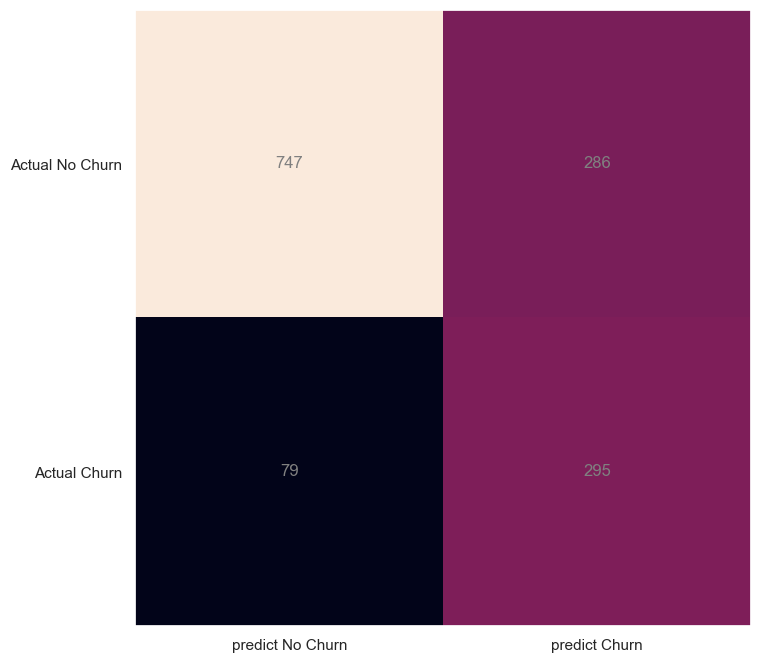

In [42]:
# Selecionando o melhor modelo
modelo = XGBClassifier(**melhores_hiperparametros['XGB'], scale_pos_weight=sum(y_train == 0)/sum(y_train == 1))

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred) 
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('predict No Churn', 'predict Churn'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual No Churn', 'Actual Churn'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='gray')


plt.show()

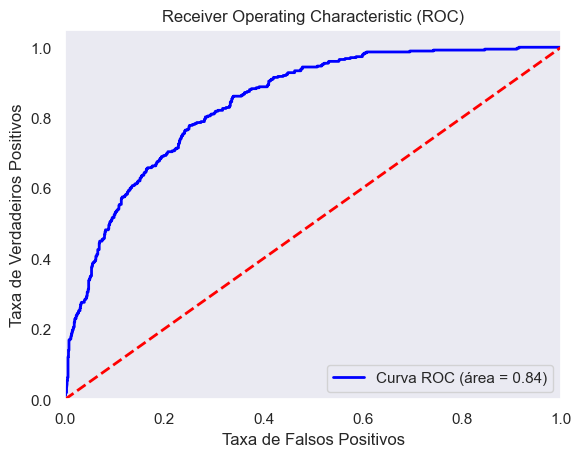

In [43]:
# Obter as probabilidades de predição
y_pred_proba = modelo.predict_proba(X_test)[:, 1]

# Calcular as taxas de verdadeiros positivos e falsos positivos
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcular a AUC (Área sob a Curva) 
roc_auc = auc(fpr, tpr)

# Plotar o gráfico ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### Interpretação dos Resultados

- **Com base no gráfico acima, observa-se que a área sob a curva ROC é de 0.84, o que indica uma performance bastante positiva do modelo de classificação. Este resultado é especialmente relevante no contexto do projeto, uma vez que prever o Churn de um cliente pode trazer benefícios significativos para a empresa, como melhorar a retenção de clientes e aumentar a satisfação. Embora a previsão de churn possa não ser tão crítica quanto a prevenção de fraudes em cartões de crédito ou o diagnóstico e prevenção de doenças médicas, ela desempenha um papel crucial na estratégia de negócios e no sucesso a longo prazo da organização.**


- **Com relação à matriz de confusão, observa-se que o Recall para Churn, uma métrica crucial no contexto deste problema de negócio, atingiu um bom valor de 0.789. Isso significa que 295 dos 374 (78.9%) dos casos de churn foram corretamente identificados como tal.**

### 8. Tentando melhorar o modelo removendo features menos importantes

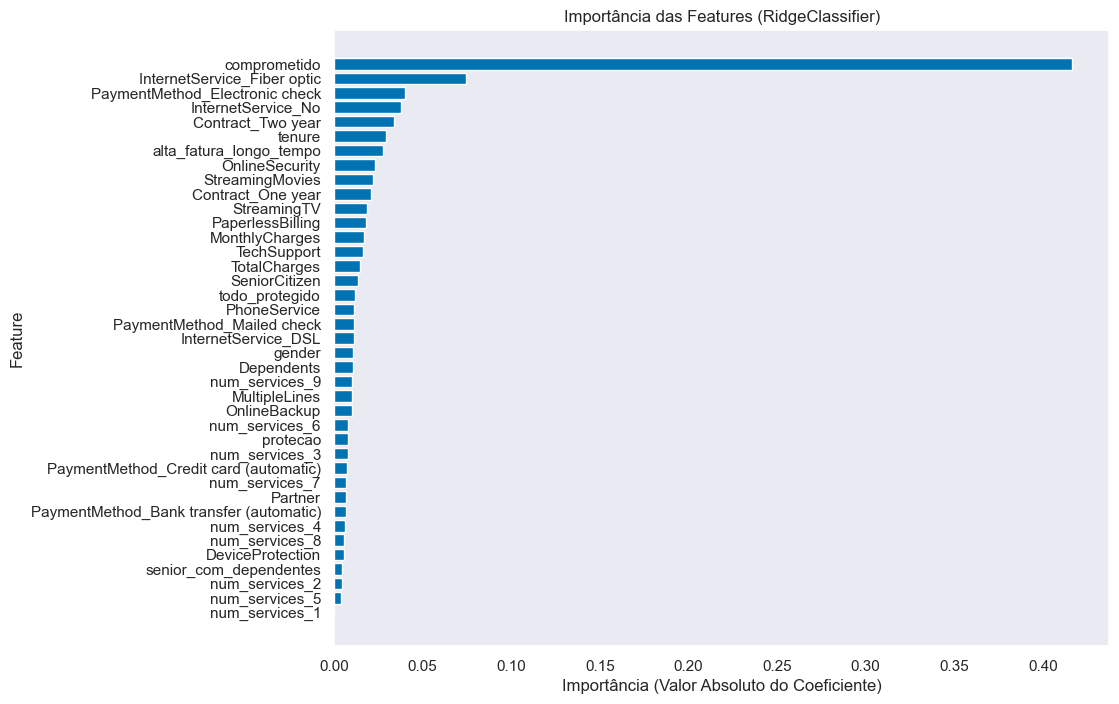

In [44]:
# Selecionando o melhor modelo
modelo = XGBClassifier(**melhores_hiperparametros['XGB'], scale_pos_weight=sum(y_train == 0)/sum(y_train == 1)) 

# Treinando o modelo
modelo.fit(X_train, y_train)

# Extraindo os coeficientes
coeficientes = modelo.feature_importances_

# Criando um DataFrame para uma melhor visualização
features_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coeficientes})
features_df['Importance'] = np.abs(features_df['Coefficient'])
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotando o gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importância (Valor Absoluto do Coeficiente)')
plt.ylabel('Feature')
plt.title('Importância das Features (RidgeClassifier)')
plt.gca().invert_yaxis()  # Inverter a ordem das features
plt.show()

In [45]:
# Selecionar as features com importância menor que o valor limite
limite_importancia = 0.01
features_menor_importancia = features_df[features_df['Importance'] < limite_importancia]

# Lista de colunas a serem removidas
colunas_para_remover = features_menor_importancia['Feature'].tolist()
colunas_para_remover

['num_services_6',
 'protecao',
 'num_services_3',
 'PaymentMethod_Credit card (automatic)',
 'num_services_7',
 'Partner',
 'PaymentMethod_Bank transfer (automatic)',
 'num_services_4',
 'num_services_8',
 'DeviceProtection',
 'senior_com_dependentes',
 'num_services_2',
 'num_services_5',
 'num_services_1']

In [46]:
# Remover as colunas do DataFrame original
df_modificado = normal_df.drop(columns=colunas_para_remover)

In [47]:
# criando X e y a partir dos dados normalizados
X = df_modificado.drop(columns='Churn', axis=1)
y = df_modificado['Churn']

# criando X, y de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 25), (1407, 25), (5625,), (1407,))

In [48]:
for nome_modelo, modelo in modelos_otimizados.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Usando apenas F1-Score como métrica de avaliação
    score = f1_score(y_test, y_pred)
    
    print(f'{nome_modelo}: {score:.5f}')

XGB: 0.61940
ExtraTrees: 0.61366
SVC: 0.60963
Ridge: 0.63080
DecisionTree: 0.58800


- **Pequena melhora no modelo RidgeClassifier (0.63080 contra 0.62620)**

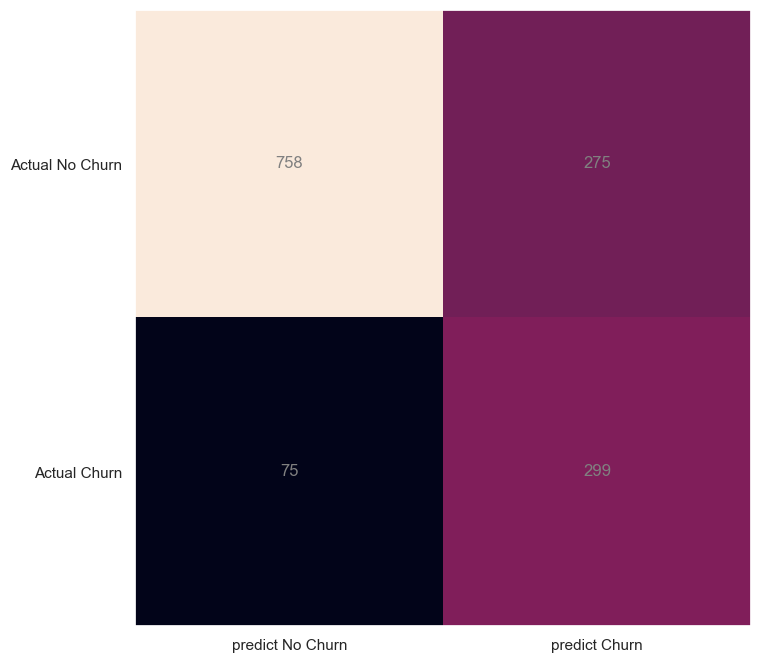

In [49]:
# Selecionando o modelo
modelo = RidgeClassifier(**melhores_hiperparametros['Ridge'], class_weight='balanced')

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred) 
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('predict No Churn', 'predict Churn'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual No Churn', 'Actual Churn'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='gray')


plt.show()

- **Após remover algumas features menos importantes e simplificar o modelo, percebeu-se uma pequena melhora no Recall, saindo de 0.789 para 0.799 (299/374).**

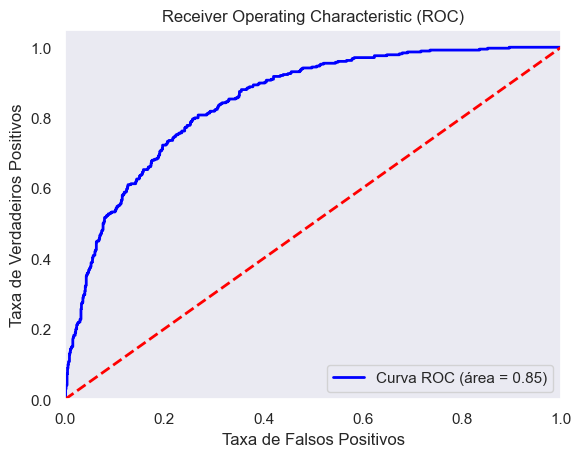

In [50]:
# Calibrando o modelo para obter predições probabilísticas
calibrated_model = CalibratedClassifierCV(modelo, method='sigmoid')
calibrated_model.fit(X_train, y_train)

# Obter as probabilidades de predição
y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]

# Calcular as taxas de verdadeiros positivos e falsos positivos
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcular a AUC (Área sob a Curva) 
roc_auc = auc(fpr, tpr)

# Plotar o gráfico ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

- **Já para o caso da Curva ROC e sua área AUC, não houve impacto.**